# 문서 특징
- ImageDataGenerator로 이미지 전처리
    - train 데이터 확보를 위해 평행이동, 좌우반전한 이미지도 generate해서 학습
    - https://tykimos.github.io/2017/06/10/CNN_Data_Augmentation/ 참고
- RGB 이미지로 학습
- 640,480 사이즈로 이미지 resize후 학습
- image_dataset_from_directory 시도했으나 결과물이 ImageDataset이어서 indexing을 할 수 없는 구조라서 사용하는데 어려움이 있었음
- [폴더 구조]
> --- images
        --- train
            --- 0
            --- 1
        --- test
            --- 0
            --- 1  
        --- labeled
            --- 0
            --- 1

In [1]:
## execute on colab
from google.colab import drive
drive.mount('/content/drive')
% cd /content/drive/My Drive/supergate/Image_Detector/object_detection
% ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/supergate/Image_Detector/object_detection
01_line_detection.ipynb    04_train_total_img.ipynb  make_labeled_dir.py
02.img_model_generator.py  05_train_gray.ipynb       model/
02_train.py                images/                   restore_img_folder.py
03_train.ipynb             make_img_f_list.py


In [2]:
# 버전 확인
# ! pip list | grep tensor

In [3]:
# ! mkdir ./images
# ! mkdir ./images/labeled/0
# ! mkdir ./images/labeled/1

In [4]:
# ! python make_labeled_dir.py

In [12]:
# # 이미지 전처리 - grayscale
# import tensorflow as tf
# from tensorflow.keras.preprocessing import image_dataset_from_directory
# train_generator=image_dataset_from_directory(
#     'images/labeled',
#     labels="inferred",
#     label_mode="int",
#     class_names=None,
#     color_mode="grayscale",
#     batch_size=32,
#     image_size=(640, 480),
#     shuffle=True,
#     seed=33,
#     validation_split=0.3,
#     subset="training",
#     interpolation="bicubic",
# )
 
# validation_generator =image_dataset_from_directory(
#     'images/labeled',
#     labels="inferred",
#     label_mode="int",
#     class_names=None,
#     color_mode="grayscale",
#     batch_size=32,
#     image_size=(640, 480),
#     shuffle=True,
#     seed=33,
#     validation_split=0.3,
#     subset="validation",
#     interpolation="bicubic",
# )


### [참고] tutorial of flow_from_directory
https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

In [31]:
##이미지 전처리
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'images/train',
        target_size=(640, 480),
        batch_size=32,
        class_mode='binary',
        color_mode="grayscale")
validation_generator = test_datagen.flow_from_directory(
        'images/test',
        target_size=(640, 480),
        batch_size=32,
        class_mode='binary',
        color_mode="grayscale")


Found 258 images belonging to 2 classes.
Found 112 images belonging to 2 classes.


In [32]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 640, 480, 1)
(32,)


In [33]:
# import os
import cv2
import numpy as np
import tensorflow as tf
# import matplotlib.pyplot as plt
# from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
# from tensorflow.python.keras.utils.vis_utils import plot_model
import pandas as pd
import argparse
from sklearn.model_selection import train_test_split
import pickle


# 모델정의
model = Sequential()
#CNN-1
model.add(Conv2D(
    # input_shape=X.shape[1:],  #(640, 480, 3) ,color image
    input_shape=(640, 480,1),
    filters=128,
    kernel_size=(3,3),
    strides=(1,1),
    padding="same",
    activation='relu',
))
model.add(MaxPooling2D(pool_size=(3, 3)))
#cnn-2
model.add(Conv2D(
    filters=64,
    kernel_size=(4,4),
    strides=(2,2),
    padding="same",
    activation='relu',
))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.02))
#cnn-3
model.add(Conv2D(
    filters=32,
    kernel_size=(3,3),
    strides=(1,1),
    padding="same",
    activation='relu',
))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.02))
model.add(Conv2D(32,kernel_size=(2,2)))
model.add(MaxPooling2D(pool_size=(2, 2)))
# fully-connected
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 640, 480, 128)     1280      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 213, 160, 128)     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 107, 80, 64)       131136    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 53, 40, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 53, 40, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 53, 40, 32)        18464     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 26, 20, 32)       

In [34]:
#compile
model.compile(optimizer='adam',
loss = tf.keras.losses.BinaryCrossentropy(),
metrics= ['accuracy'],
)


In [35]:
# STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
# model.fit(train_generator,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=validation_generator,
#                     validation_steps=STEP_SIZE_VALID,
#                     epochs=30
# )

# old version
history=model.fit(
        train_generator,
        epochs=30,
        validation_data=validation_generator)

Epoch 1/30
9/9 [==============================] - 40s 4s/step - loss: 0.7153 - accuracy: 0.5271 - val_loss: 0.6763 - val_accuracy: 0.5893
Epoch 2/30
9/9 [==============================] - 28s 3s/step - loss: 0.6954 - accuracy: 0.5465 - val_loss: 0.6963 - val_accuracy: 0.4643
Epoch 3/30
9/9 [==============================] - 28s 3s/step - loss: 0.6973 - accuracy: 0.5039 - val_loss: 0.7197 - val_accuracy: 0.4107
Epoch 4/30
9/9 [==============================] - 29s 3s/step - loss: 0.6894 - accuracy: 0.5504 - val_loss: 0.6813 - val_accuracy: 0.5625
Epoch 5/30
9/9 [==============================] - 28s 3s/step - loss: 0.6756 - accuracy: 0.5969 - val_loss: 0.6656 - val_accuracy: 0.5982
Epoch 6/30
9/9 [==============================] - 28s 3s/step - loss: 0.6735 - accuracy: 0.5853 - val_loss: 0.6748 - val_accuracy: 0.5804
Epoch 7/30
9/9 [==============================] - 28s 3s/step - loss: 0.6484 - accuracy: 0.6202 - val_loss: 0.6844 - val_accuracy: 0.5536
Epoch 8/30
9/9 [==================

In [37]:
model.evaluate_generator(generator=validation_generator)


Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.674858033657074, 0.625]

In [38]:
result_batch = model.predict(validation_generator)

In [39]:
pd.DataFrame(zip(np.round(result_batch[:,0]),validation_generator[0][1]),columns=['prediction','true'])

,prediction,true
0,0.0,0.0
1,0.0,0.0
2,1.0,1.0
3,0.0,0.0
4,1.0,0.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,1.0,1.0
9,0.0,1.0


In [ ]:
# convert single image to gray scale
# image = tf.keras.preprocessing.image.load_img(image_path)
# input_arr = keras.preprocessing.image.img_to_array(image)
# input_arr = np.array([input_arr])  # Convert single image to a batch.
# predictions = model.predict(input_arr)

array([20, 23,  8, 18, 14])

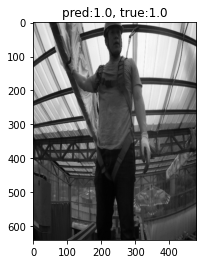

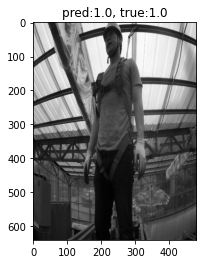

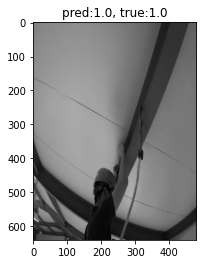

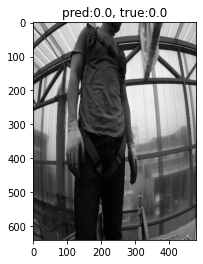

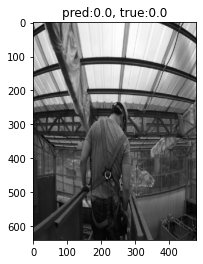

In [42]:
import matplotlib.pyplot as plt
idx =np.random.choice(len(validation_generator[0][0]),size=5, replace=False)
image_batch, labels_batch = validation_generator[0]
for i in idx:
    plt.figure()
    plt.imshow(image_batch[i].reshape((640,480)),'gray')
    result = model.predict(np.expand_dims(image_batch[i],axis=0))[0,0]
    plt.title(f"pred:{round(result)}, true:{labels_batch[i]}")
    plt.show()


In [43]:
import os
test_loss, test_acc = model.evaluate(validation_generator,verbose=0)
print(f"validation loss:{test_loss}")
print(f"validation accuracy:{test_acc}")
# 모델 저장
model.save('./model/model_total_gray.h5')

validation loss:0.674858033657074
validation accuracy:0.625


## validation accuracy가 너무 낮음
```
color:
validation loss:0.6570543199777603
validation accuracy:0.6339285969734192

gray:
validation loss:0.674858033657074
validation accuracy:0.625
```

- gray scale도 성능이 낮다
- detect 한 정보만 추출해보자
    - detect 해서 박스 안에 있는 정보는 살리고 나머지는 0행렬
    - 또는 박스 안에 있는 정보를 클래스 idx로 채워서 보내기